In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from gensim import models, corpora
import re
from ast import literal_eval
from wordcloud import WordCloud
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import umap
warnings.filterwarnings('ignore')
%matplotlib inline

## Считывание датасета

##### Набор данных содержит комментатрии из разных музыкальных групп ВК.

In [2]:
df = pd.read_csv('C:/Users/v_rusakevich/Documents/reduced_comments_vk.csv')

In [3]:
# Необходимые поля для работы - "music_style", "performer" и сам текст - "text_bow"
df.head(10)

,Unnamed: 0,audio,author,comment_id,date,dirty_text,emoji,likes,link,music_style,performer,stickers,text,video,text_bow,comment_len
0,9,NaN,146608415,52228413_282387_282503,2019-01-01 17:43:48,"[id415608045|Иван],\nВ который раз, весь мир л...",NaN,1,NaN,estrada,лепс,NaN,id415608045 иван который весь мир лететь чужое...,NaN,"['id415608045', 'иван', 'который', 'весь', 'ми...",79.0
1,103,NaN,197130573,52228413_282259_282287,2018-12-31 13:47:29,С Наступающим!. Пусть старый год уходя оставит...,NaN,2,NaN,estrada,лепс,NaN,наступать пусть старый год уходить оставить ве...,NaN,"['наступать', 'пусть', 'старый', 'год', 'уходи...",42.0
2,107,NaN,-52228413,52228413_282158_282162,2018-12-30 21:04:56,Автор музыки и слов - Дмитрий Митькин.\n\nВ ко...,NaN,29,NaN,estrada,лепс,NaN,автор музыка слово дмитрий митькина который ве...,NaN,"['автор', 'музыка', 'слово', 'дмитрий', 'митьк...",82.0
3,130,NaN,197130573,52228413_282158_282211,2018-12-30 23:04:28,Ура!!!🔥🔥🔥🔥🔥🔥🔥🔥 Предновогодняя премьера от непо...,🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥👍👍👍👍👍👍👍👍💪💪💪💪💪💪💪💪🔥🔥😎😎😎,6,NaN,estrada,лепс,NaN,ура предновогодний премьера неподражаемый непр...,NaN,"['ура', 'предновогодний', 'премьера', 'неподра...",43.0
4,190,NaN,208434900,52228413_282010_282031,2018-12-29 17:18:25,"Легко. ""Аминь""- лучший клип ГВ за последнее вр...",NaN,4,NaN,estrada,лепс,NaN,легко аминь хороший клип последний время полны...,NaN,"['легко', 'аминь', 'хороший', 'клип', 'последн...",70.0
5,283,NaN,146608415,52228413_281759_281838,2018-12-27 03:22:30,Григорий Лепс - Это стоит\n\nПлачет небо номер...,NaN,25,NaN,estrada,лепс,NaN,григорий лепс это стоить плакать небо номер ме...,григорий лепс это стоить рождество григорий ле...,"['григорий', 'лепс', 'это', 'стоить', 'плакать...",67.0
6,373,NaN,136911996,52228413_281537_281587,2018-12-24 04:30:05,"[id208434900|Валера], есть артист, который пра...",NaN,4,NaN,estrada,лепс,NaN,id208434900 валер артист который практически п...,NaN,"['id208434900', 'валер', 'артист', 'который', ...",48.0
7,378,NaN,136911996,52228413_281537_281621,2018-12-25 03:08:59,"[id153964488|Дима], ты тон смени, пока я тебя ...",NaN,0,NaN,estrada,лепс,NaN,id153964488 дима тон сменить пока огорчить кас...,NaN,"['id153964488', 'дима', 'тон', 'сменить', 'пок...",48.0
8,428,NaN,146608415,52228413_281244_281245,2018-12-20 12:42:41,«Я решил помочь художнику Григорию Гукасову из...,NaN,31,NaN,estrada,лепс,NaN,решить помочь художник григорий гукасова санкт...,NaN,"['решить', 'помочь', 'художник', 'григорий', '...",47.0
9,469,NaN,69588394,52228413_281188_281316,2018-12-20 21:27:57,Повторю уже сказанные многими слова - наверное...,NaN,6,NaN,estrada,лепс,NaN,повторить сказать многий слово наверное один п...,NaN,"['повторить', 'сказать', 'многий', 'слово', 'н...",41.0


In [4]:
# Размер датасета
df.shape

(105377, 16)

In [5]:
# Составляем мешок слов, поскольку предварительная обработка была проведена, то переводим строки в списки токенов
bag_of_words = df.text_bow.apply(literal_eval)

## Построение модели LDA

In [6]:
%%time
# Добавляем биграммы в мешок слов
bigram = models.Phrases(bag_of_words, min_count=3, threshold=5) 
bigram_mod = models.phrases.Phraser(bigram) 
def make_bigrams(texts): 
    return [bigram_mod[doc] for doc in texts] # и генерируем текст с биграммами 
#
texts = make_bigrams(bag_of_words)

Wall time: 1min 21s


In [7]:
%%time
# Составляем словарь из терминов 
dictionary = corpora.Dictionary(texts) 

Wall time: 9.91 s


In [8]:
%%time
# Убираем слишком редкие (no_below) и слишком частые (no_above) слова
dictionary.filter_extremes(no_below=3, no_above=0.4, keep_n=3*10**6) 

Wall time: 655 ms


In [9]:
%%time
# Составляем финальный готовый корпус 
corpus = [dictionary.doc2bow(text) for text in texts] 

Wall time: 6.83 s


In [10]:
%%time
# Строим LDA модель
ldamodel = models.ldamodel.LdaModel( corpus=corpus, id2word=dictionary, eval_every=20, num_topics=30, passes=5)

Wall time: 5min 37s


In [11]:
%%time
# Получаем 100 самых вероятных слов для каждой темы
topics = ldamodel.show_topics( num_topics=30, num_words=100, formatted=False)

Wall time: 32 ms


## Визуализация

Wall time: 8.34 s


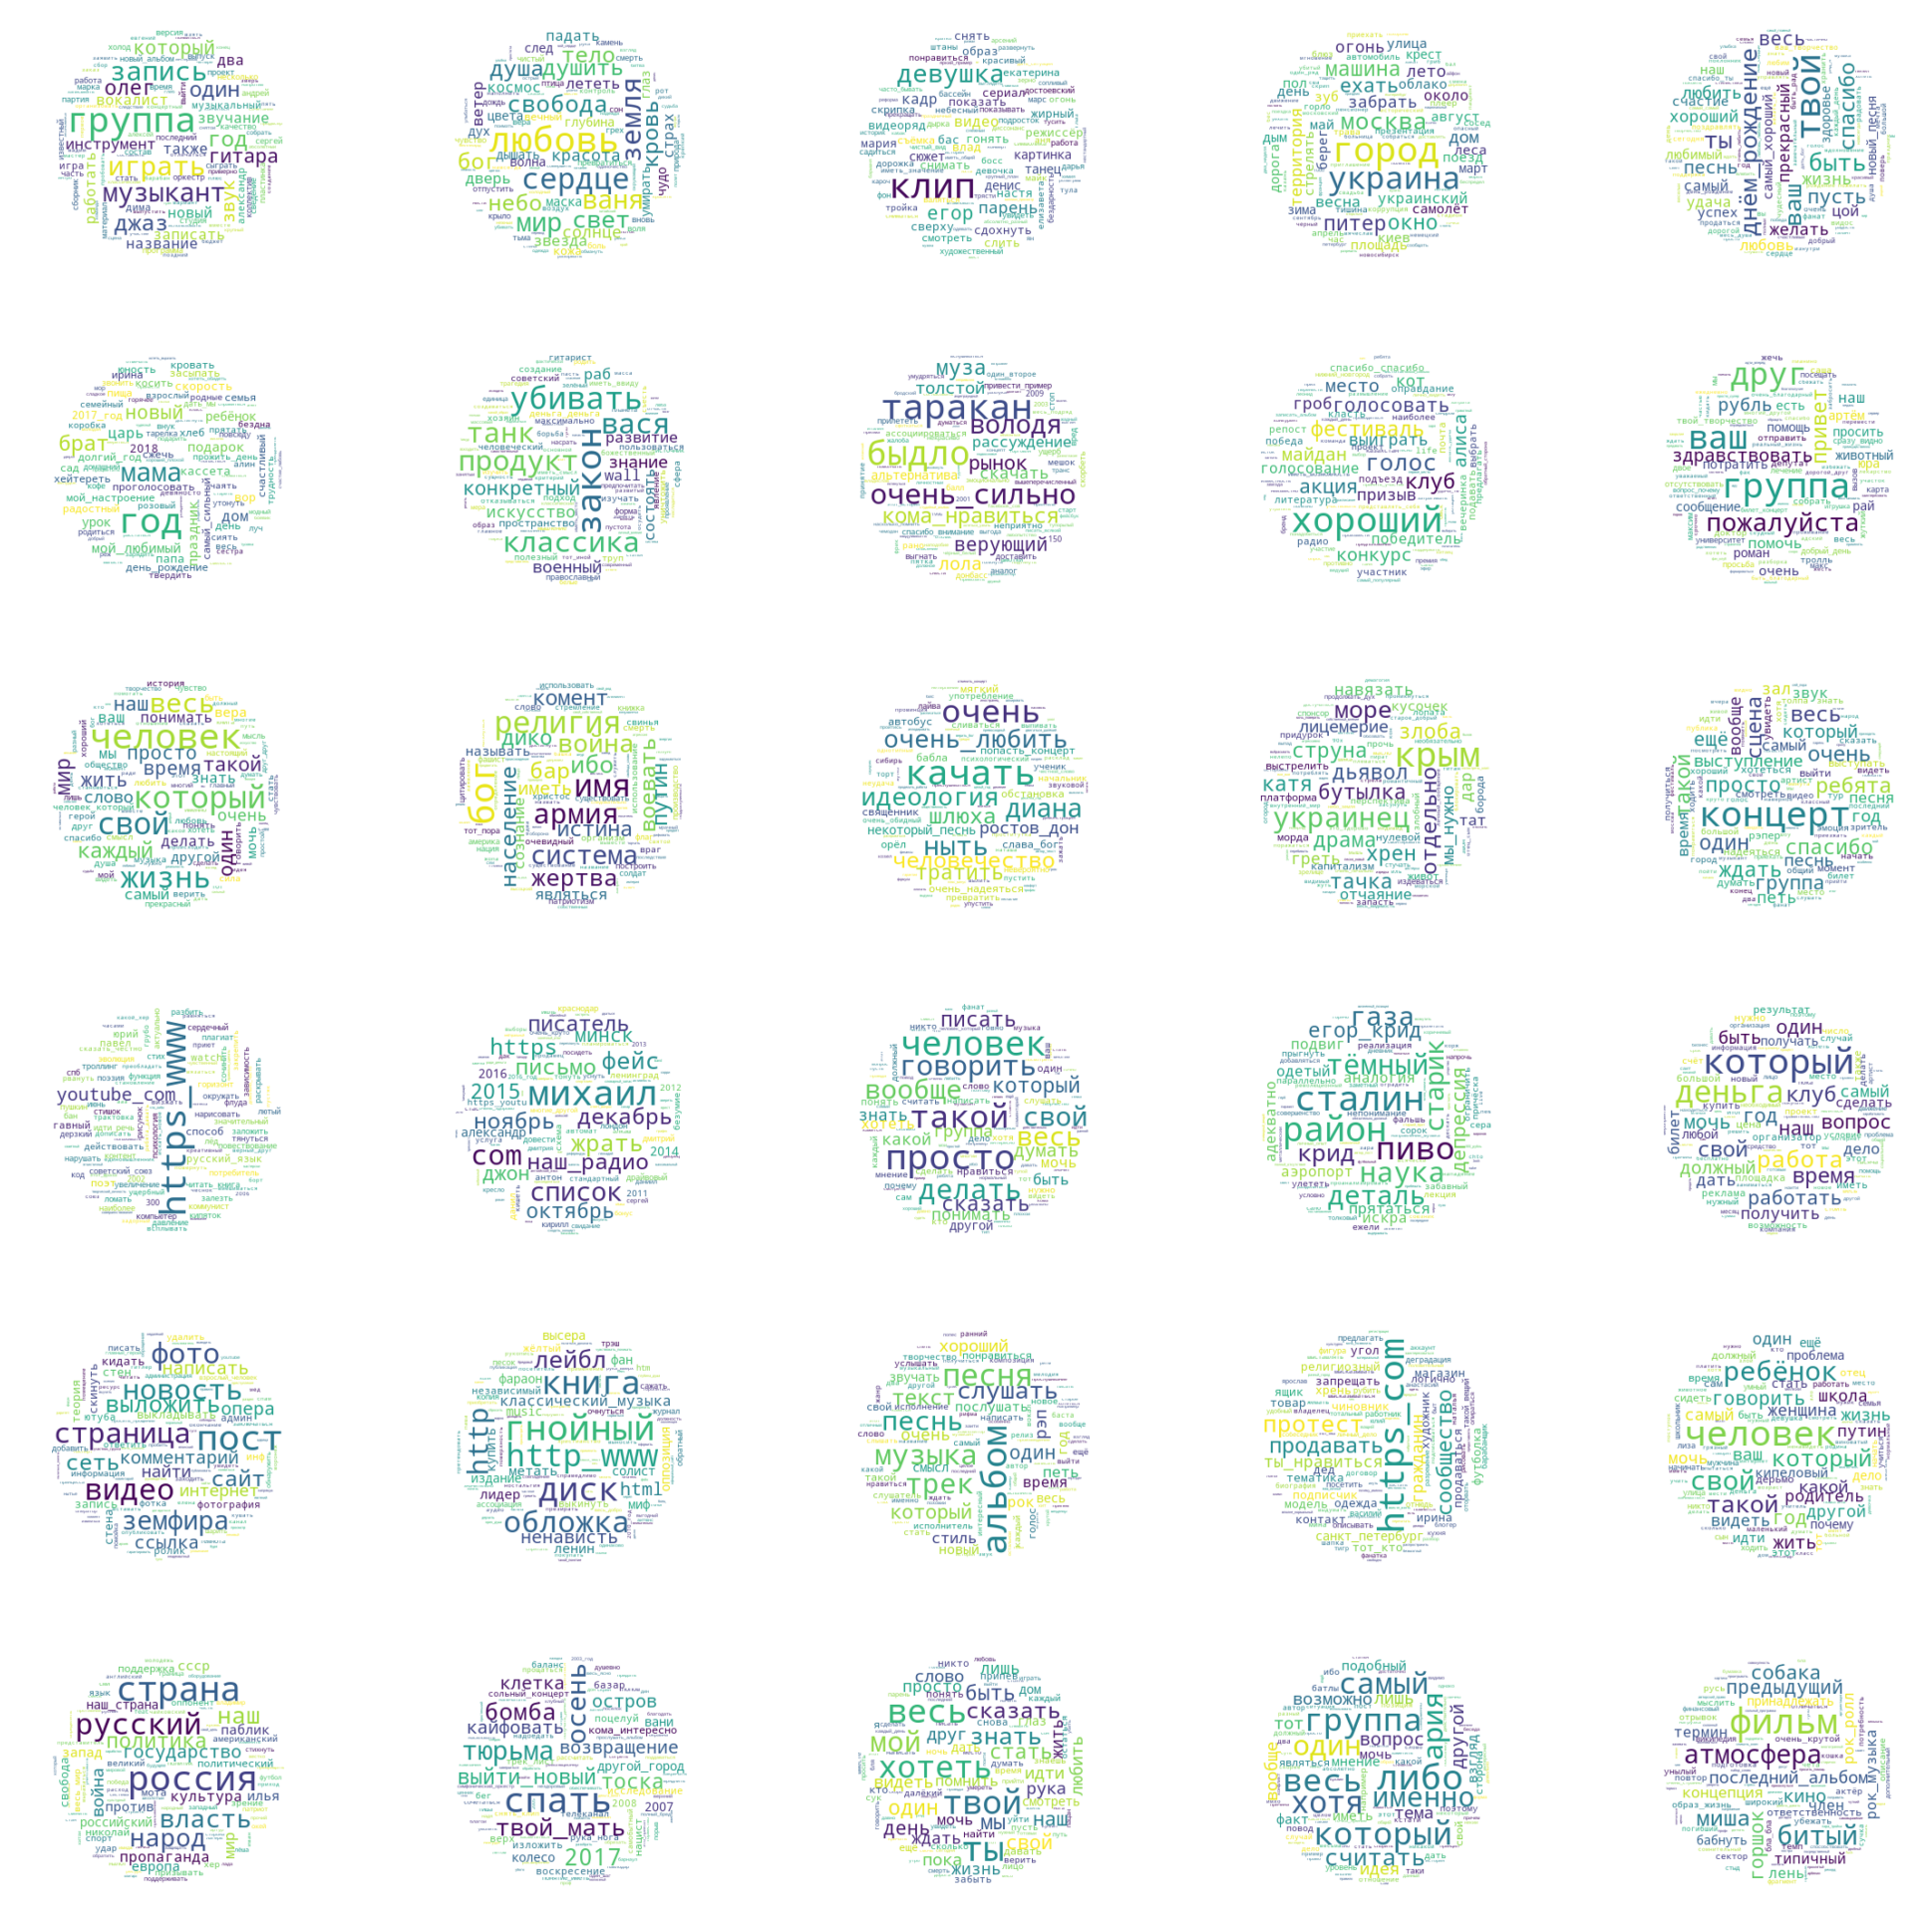

In [12]:
%%time
# Визуализация каждого топика
x, y = np.ogrid[:300, :300]
mask = (x - 150) ** 2 + (y - 150) ** 2 > 130** 2
mask = 255 * mask.astype(int)
fig, axs = plt.subplots(6, 5, figsize=(35, 35))
j = 0
for i in topics:
    ax = axs[j//5,j%5]
    wordcloud = WordCloud(max_font_size=40, background_color="white", mask=mask).generate_from_frequencies(dict(i[1]))
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.axis("off")
    j += 1

In [13]:
# Векторы тем
vector = pd.DataFrame([dict(i) for i in ldamodel.get_document_topics(corpus, minimum_probability=0)])

Heatmap жанров музыки

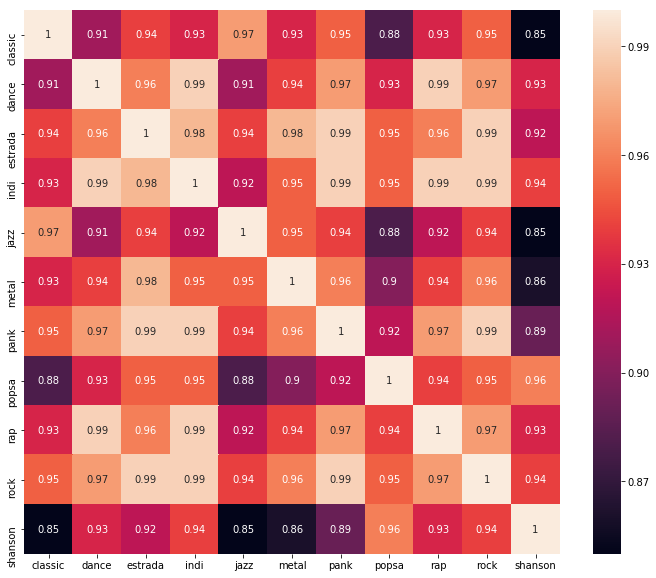

In [14]:
# Визуализация heatmap, показывающая насколько близки жанры музыки по косинусному расстоянию между темами обсуждаемыми в них
total = pd.concat([df[['music_style', 'performer']], vector], axis=1)
ind = total.groupby(['music_style']).mean().index
plt.figure(figsize=(12, 10))
sns.heatmap(np.round(cosine_similarity(total.groupby(['music_style']).mean()),2), annot=True, xticklabels=ind, yticklabels=ind)
plt.show()

UMAP визуализация

In [15]:
performer = total.groupby(['performer','music_style']).mean().reset_index()
music_style = total.groupby(['music_style']).mean().reset_index()

In [16]:
um = umap.UMAP(metric='cosine', min_dist=0.0)
u1 = um.fit_transform(performer.iloc[:,2:])
u2 = um.fit_transform(music_style.iloc[:,1:])

In [17]:
performer = np.concatenate((performer.iloc[:,:2], u1), axis=1)
music_style = np.concatenate((music_style.iloc[:,:1], u2), axis=1)

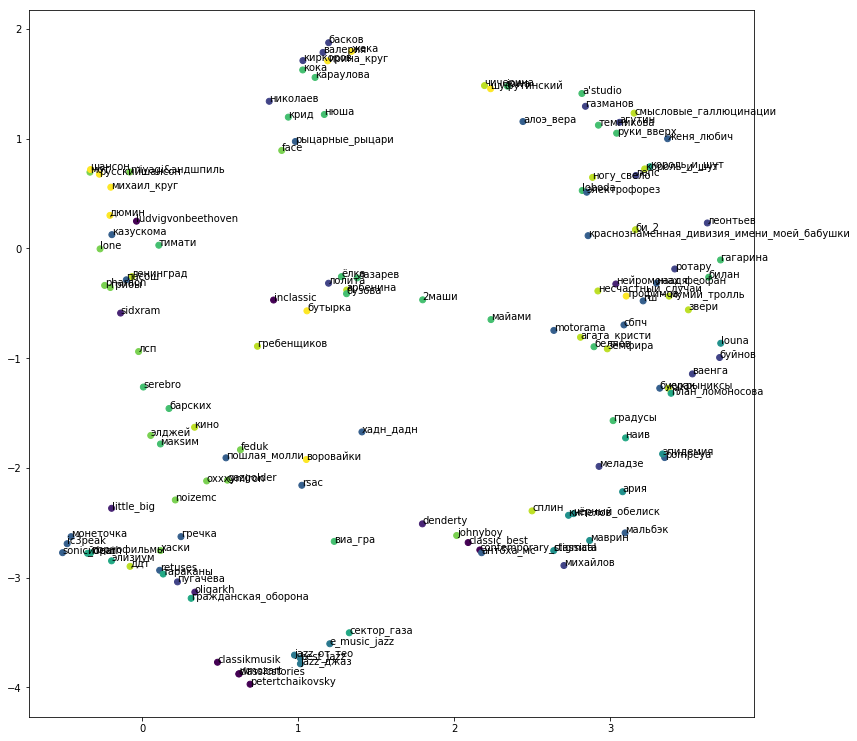

In [18]:
# По исполнителям
plt.figure(figsize=(13, 13))
l = LabelEncoder()
plt.scatter(performer[:,2], performer[:,3], c=l.fit_transform(performer[:,1]))
for x,y,z in zip(performer[:,2], performer[:,3], performer[:,0]):
    label = "{}".format(z)
    plt.annotate(label, (x,y))
plt.show()

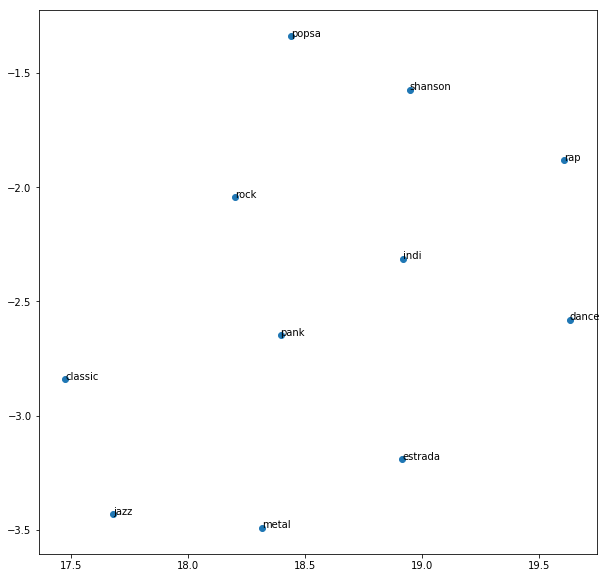

In [19]:
# По жанрам
plt.figure(figsize=(10, 10))
l = LabelEncoder()
plt.scatter(music_style[:,1], music_style[:,2])
for x,y,z in zip(music_style[:,1], music_style[:,2], music_style[:,0]):
    label = "{}".format(z)
    plt.annotate(label, (x,y))
plt.show()

###### Получилось, например, что к инди ближе всего к року и панку, а рэп к дэнсу. А наиболее отдаленные, например, шансон от классики, джаза и металла.